<div class="alert alert-info">
    <h1><strong>BitCamp Hackathon:</strong> Quantum Track </h1>
    <h2><strong> Challenge 4 -</strong> VQE for Chemistry</h2>
</div>

In [3]:
# Imports!
from qiskit import Aer, IBMQ
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.applications import Knapsack
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2, QAOAAnsatz
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.load_account()
print("Libraries imported successfully")
%matplotlib widget

Libraries imported successfully


# Finding the structure of a molecule

## Defining the system

The first step is to define the molecular system. In the following we ask for the electronic part of a hydrogen molecule.

Qiskit is interfaced with different classical codes which are able to find the molecular structure. Interfacing between Qiskit and the following codes is already available: Gaussian, Psi4, PyQuante, PySCF.

In the following we set up a PySCF driver, for the hydrogen molecule with the two atoms at a distance of 0.8 angstrom from each other.

In [2]:
#Block 7 - Specifying the parameters of the molecule
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.8]]],
                     charge=0, multiplicity=1)    # You can vary the distance between the atoms by changing 0.8
structure_problem = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM)
qubit_converter = QubitConverter(JordanWignerMapper())

/tmp/ipykernel_61/1377952087.py:5: DeprecationWarning: The PySCFDriver class is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the PySCFDriver class from qiskit_nature.drivers.second_quantization.pyscfd.
  structure_problem = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM)


## NumPyMinimumEigensolver

A solver is the algorithm through which the ground state is computed.

Let’s first start with a purely classical example: the NumPy minimum eigensolver. This algorithm exactly solves the structure for the molecule. The hydrogen molecule is small enough that we can solve it exactly using a classical solver. Although the classical solver scales badly, i.e., it takes a very long time to solve larger molecules, it can be used on small systems to check the results of the quantum algorithms.

Run the block below to solve the problem using the classical solver.

In [3]:
#Block 8 - Solving using classical solver
method = NumPyMinimumEigensolver()

calc = GroundStateEigensolver(qubit_converter, method)
result = calc.solve(ElectronicStructureProblem(structure_problem))
print("Total energy = ", result.total_energies)

Total energy =  [-1.13414767]


The most important number here is the total energy. Keep it in mind! We will compare the result we get with the VQE solver with this result.

## VQE Solver

Now, we are going to find the energy of this molecule using VQE. To simulate the performance on a real device, let's create a noise model based on ibmq_belem just as we had done in the benchmarking lab.

In [4]:
# Block 9 - Defining a noise model 
backend_belem = provider.get_backend('ibmq_belem')   # Specifying which backend to use
noise_model_belem = NoiseModel.from_backend(backend_belem)  # Creating a noise model from this backend.

Next, we are going to set up VQE. THis is very similar to the setup we had done for the knapsack problem. Below, we have defined a tunable circuit and a classical optimizer and put those together using Qiskit's VQE function.

Don't worry about `QuantumInstance` - it is a way in Qiskit to specify the backend and the noise model together for the VQE simulation.

In [5]:
#Block 10 - Setting up VQE

qinstance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'), noise_model = noise_model_belem)

tunable_circuit = EfficientSU2(reps= 1, entanglement='full') # This is the tunable circuit - this is the quantum part of VQE
optimizer = COBYLA(maxiter=500) # Classical optimizer - this is the classical part of VQE
method = VQE(ansatz = tunable_circuit, optimizer = optimizer, quantum_instance = qinstance)# Putting everything together using Qiskit's VQE function

Finally, it's time to find the energy of this structure and print the results!

In [6]:
#Block 11 - Solving using VQE
calc = GroundStateEigensolver(qubit_converter, method)
result = calc.solve(ElectronicStructureProblem(structure_problem))


In [7]:
# Block 12 - Printing results
print("Total energy = ", result.total_energies)
print("Error = ", (-1.13728568 - result.total_energies)/(-1.13728568)*100) 

Total energy =  [-0.68334768]
Error =  [39.91415779]


How does the total energy here compare with the exact solution?

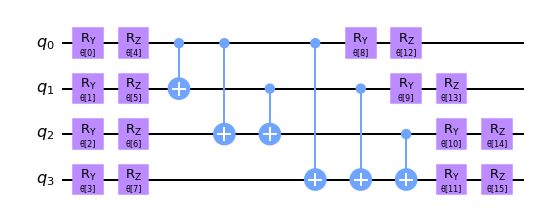

In [24]:
# Block 13 - Drawing the tunable circuit
tunable_circuit.decompose().draw()

# Activities:
1. Can you tweak your tunable circuit so that your total energy is closer to the exact solution? 
2. What is the least number of repetitions that still gives you a good match with the exact solution?
3. What happens when there are more repetitions? Do you notice errors?
4. Change the distance between the atoms in Block 13. Can you find the distance that minimizes the total energy?

# Extra content

In the lab, we showed you how we can find the energy for one distance between the hydrogen atoms. Now, let's find the energies for many distances, and in the process, find the lowest possible energy. The distance at which we get the lowest energy corresponds to the ground state bond length of the hydrogen molecule!

In [31]:
#Block 14 - Creating energy diagram using classical solver
method = NumPyMinimumEigensolver()

calc = GroundStateEigensolver(qubit_converter, method)
classical_energies = []
distances = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5]

for i in range(len(distances)):
    # Create a variable to select the value from distances at the current index i
    molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                                ['H', [0., 0., distances[i]]]], # insert the variable from the previous line here
                      charge=0, multiplicity=1)
    structure_problem = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM)
    result = calc.solve(ElectronicStructureProblem(structure_problem))
    classical_energies.append(result.total_energies)
    print("Completed", i+1, "out of", str(len(distances)), "calculations")

Completed 1 out of 13 calculations
Completed 2 out of 13 calculations
Completed 3 out of 13 calculations
Completed 4 out of 13 calculations
Completed 5 out of 13 calculations
Completed 6 out of 13 calculations
Completed 7 out of 13 calculations
Completed 8 out of 13 calculations
Completed 9 out of 13 calculations
Completed 10 out of 13 calculations
Completed 11 out of 13 calculations
Completed 12 out of 13 calculations
Completed 13 out of 13 calculations


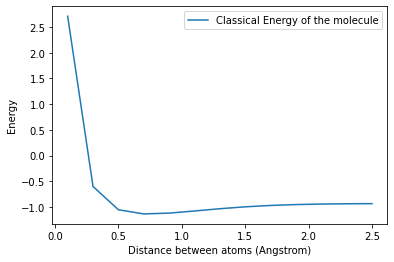

In [32]:
#Block 15 - Plotting classical energy diagram

plt.plot(distances, classical_energies, label="Classical Energy of the molecule")
plt.xlabel('Distance between atoms (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [33]:
#Block 16 - Obtaining VQE energy diagram
qinstance = QuantumInstance(backend = Aer.get_backend('statevector_simulator'), noise_model = noise_model_belem)
tunable_circuit = EfficientSU2(reps= 1, entanglement='full') # Tunable quantum circuit
optimizer = COBYLA(maxiter=100) # Classical optimizer - this is the classical part of VQE
method = VQE(ansatz = tunable_circuit, optimizer = optimizer, quantum_instance = qinstance)# Putting everything together using Qiskit's VQE function
calc = GroundStateEigensolver(qubit_converter, method)

vqe_energies = []
distances = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5]
for i in range(len(distances)):
    dist = distances[i]
    molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                                ['H', [0., 0., dist]]],
                      charge=0, multiplicity=1)
    structure_problem = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
    result = calc.solve(ElectronicStructureProblem(structure_problem))
    vqe_energies.append(result.total_energies)
    print("Completed", i+1, "out of", str(len(distances)), "calculations")

Completed 1 out of 13 calculations
Completed 2 out of 13 calculations
Completed 3 out of 13 calculations
Completed 4 out of 13 calculations
Completed 5 out of 13 calculations
Completed 6 out of 13 calculations
Completed 7 out of 13 calculations
Completed 8 out of 13 calculations
Completed 9 out of 13 calculations
Completed 10 out of 13 calculations
Completed 11 out of 13 calculations
Completed 12 out of 13 calculations
Completed 13 out of 13 calculations


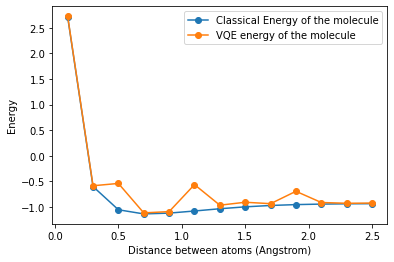

In [34]:
#Block 17 - Plotting VQE energy diagram
plt.plot(distances, classical_energies, distances, vqe_energies,marker = "o")
plt.xlabel('Distance between atoms (Angstrom)')
plt.ylabel('Energy')
plt.legend(['Classical Energy of the molecule','VQE energy of the molecule'])
plt.show()

### © 2022 The Coding School

**All rights reserved**

*Use of this activity is for personal use only. Copying, reproducing, distributing, posting or sharing this activity in any manner with any third party are prohibited under the terms of this registration. All rights not specifically licensed under the registration are reserved.*